# Imports

In [1]:
import logging
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from brainflow import *
from keras import layers
from matplotlib import pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

2023-03-03 16:45:34.900585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 16:45:35.011945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 16:45:35.011963: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-03 16:45:35.681996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Data Loading

## Train

In [2]:
raw_training = DataFilter.read_file("../data/training_EEG.csv")
# raw_training2 = DataFilter.read_file("../data/training-long_EEG.csv")
# raw_training3 = DataFilter.read_file("../data/combo_file.csv")

In [3]:
raw_training[1:9][0]

array([39155.18244 , 39159.518678, 39166.090091, ..., 26359.322829,
       26359.255774, 26359.523995])

In [4]:
# raw_training = DataFilter.read_file('drive/MyDrive/eeg/training_EEG.csv')
# raw_training = pd.DataFrame(np.transpose(raw_training))
# raw_training = raw_training3

# sample,packet,eeg1,eeg2,eeg3,eeg4,eeg5,eeg6,eeg7,eeg8,accel1,accel2,accel3,other1,other2,other3,other4,other5,other6,other7,analog1,analog2,analog3,timestamp,marker

training_raw_channels = []
for channel in range(1, 9):
    training_raw_channels.append(raw_training[channel][:])
training_raw_channels = np.array(training_raw_channels)

training_raw_times = raw_training[22][:]
training_raw_markers = raw_training[23][:]

In [5]:
print(training_raw_channels.shape)

(8, 149618)


In [6]:
raw_training = DataFilter.read_file("../data/training_EEG.csv")
raw_training = pd.DataFrame(np.transpose(raw_training))

training_raw_channels = []
for channel in range(1, 9):
    training_raw_channels.append(raw_training[channel][:])
training_raw_channels = np.array(training_raw_channels)

training_raw_times = raw_training[22][:]
training_raw_markers = raw_training[23][:]

In [7]:
raw_training.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,39155.182440,19807.132460,-34240.436165,-40674.899897,-33908.468057,-16719.015446,-20823.131004,-45843.450230,-0.04,...,192.0,13.0,224.0,5.0,128.0,0.0,0.0,0.0,1.677208e+09,0.0
1,1.0,39159.518678,19803.779698,-34371.819719,-41016.143980,-33895.302879,-16709.158326,-20883.167789,-45846.311253,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.677208e+09,0.0
2,2.0,39166.090091,19811.848678,-34367.327019,-41053.203172,-33896.085190,-16699.234152,-20875.836417,-45835.560064,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.677208e+09,0.0
3,3.0,39159.675140,19814.463832,-34245.465308,-40722.620871,-33917.744031,-16708.912457,-20824.494460,-45831.223825,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.677208e+09,0.0
4,4.0,39149.907428,19807.132460,-34235.921113,-40638.019519,-33924.382499,-16721.652951,-20828.137795,-45842.600863,-0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.677208e+09,0.0


In [8]:
(training_raw_channels.T)[0]

array([ 39155.18244 ,  19807.13246 , -34240.436165, -40674.899897,
       -33908.468057, -16719.015446, -20823.131004, -45843.45023 ])

## Test

In [9]:
raw_testing = DataFilter.read_file("../data/testing_EEG.csv")
raw_testing = pd.DataFrame(np.transpose(raw_testing))

testing_raw_channels = []
for channel in range(1, 9):
    testing_raw_channels.append(raw_testing[channel][:])
testing_raw_channels = np.array(testing_raw_channels)

testing_raw_times = raw_testing[22][:]
testing_raw_markers = raw_testing[23][:]

# Data Prep

## Trim and Scale Data

In [10]:
SCALE_FACTOR = (4500000) / 24 / (2**23 - 1)

In [11]:
# Using 250 samples per second
fs = 250

# trim and scale
training_times = np.array(training_raw_times[5 * fs : -5 * fs])
training_channels = np.array(
    [SCALE_FACTOR * training_raw_channels[n][5 * fs : -5 * fs] for n in range(8)]
)
training_spaces = np.array(training_raw_markers[5 * fs : -5 * fs])

testing_times = np.array(testing_raw_times[5 * fs : -5 * fs])
testing_channels = np.array(
    [SCALE_FACTOR * testing_raw_channels[n][5 * fs : -5 * fs] for n in range(8)]
)
testing_spaces = np.array(testing_raw_markers[5 * fs : -5 * fs])

## Filters

Notch Filters removes background power noise at 60 hz

In [12]:
def notch_filter(signal_data, notch_freq=60, notch_size=3, fs=250):
    notch_freq_Hz = np.array([float(notch_freq)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + notch_size * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (fs / 2.0), "bandstop")
        fin = signal_data = signal.lfilter(b, a, signal_data)
    return fin

Bandpass filter smooths reduces gain depending on specified frequency band

In [18]:
FREQ_LOW = 13
FREQ_HIGH = 80


def bandpass(data, lowcut=FREQ_LOW, highcut=FREQ_HIGH, fs=250):
    """Smooths and reduces gain depending on specified frequency band"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype="band")
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data


### Apply Filters

In [26]:
filtered_training = []
filtered_testing = []

for i in range(8):
    # Filter training data
    notched = notch_filter(training_channels[i].T, notch_size=8)
    bpf = bandpass(notched)
    filtered_training.append(bpf)

    # Filter testing data
    notched = notch_filter(testing_channels[i].T, notch_size=8)
    bpf = bandpass(notched)
    filtered_testing.append(bpf)

## Fourier Transforms
First we take the fourier transform of the entire dataset, averaging over all channels

In [27]:
training_fourier = []
testing_fourier = []

# Get frequency lists
training_freqs = np.fft.fftfreq(training_times.shape[-1], d=1 / fs)
testing_freqs = np.fft.fftfreq(testing_times.shape[-1], d=1 / fs)

# Get fourier transforms for each channel
for i in range(8):
    training_fourier.append(np.absolute(np.fft.fft(filtered_training[i])))
    testing_fourier.append(np.absolute(np.fft.fft(filtered_testing[i])))

# Stack fourier transforms
training_stacked = np.stack(training_fourier, axis=1)
testing_stacked = np.stack(testing_fourier, axis=1)

# Average fourier transforms
training_avg_fourier = np.mean(training_stacked, axis=1)
testing_avg_fourier = np.mean(testing_stacked, axis=1)

Plot FFT of Filtered Training Data

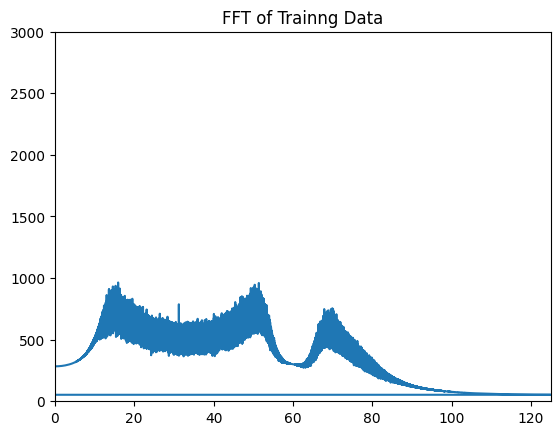

In [28]:
plt.plot(training_freqs, training_avg_fourier)
plt.xlim(0, 125)
plt.ylim(0, 3000)
plt.title("FFT of Trainng Data")
plt.show()

Plot FFT of Filtered Testing Data

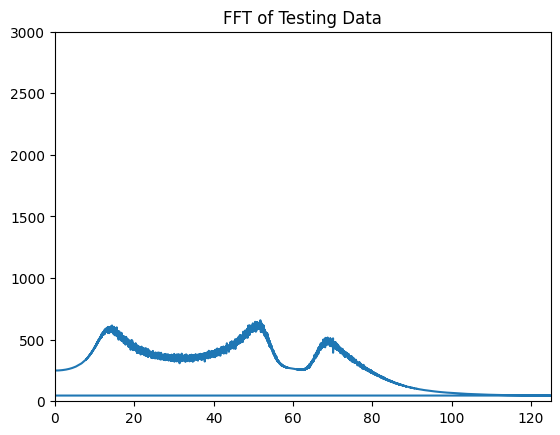

In [29]:
plt.plot(testing_freqs, testing_avg_fourier)
plt.xlim(0, 125)
plt.ylim(0, 3000)
plt.title("FFT of Testing Data")
plt.show()

Define paramaters for *(x_train, y_train)* generation

In [30]:
# Time window (in seconds) to consider preceding each space press
window_size = 0.15

# Uncertainty (in seconds) around each space press marker
space_buffer = 0.02

# Latency assumption (in seconds)
latency = 0.02

# Notch filter notch width
n_width = 6

# Range of frequencies to consider
freq_lowerbound = 13
freq_upperbound = 60

Define function to generate *(x, y)* from the given paramaters

In [31]:
def get_processed_data(
    times,
    channels,
    markers,
    window_size=window_size,
    space_buffer=space_buffer,
    latency=latency,
    n_width=n_width,
    freq_lowerbound=freq_lowerbound,
    freq_upperbound=freq_upperbound,
):
    # Define return arrays
    x_data = []
    y_data = []

    # The number of indices to consider preceding each space press
    delta_i = int(fs * window_size)

    space_i = int(fs * space_buffer)

    lat_i = int(fs * latency)

    # Number of trainingtime samples to consider
    num_samples = len(times) - delta_i - 1

    # Get frequency list
    freqs = np.fft.fftfreq(times[0:delta_i].shape[-1], d=1 / fs)

    # Record indices of chosen frequencies
    relevant_freq = []
    relevant_freq_indices = []

    for i, f in enumerate(freqs):
        if freq_lowerbound <= f <= freq_upperbound:
            relevant_freq.append(f)
            relevant_freq_indices.append(i)

    for i in range(num_samples):
        # Define window data
        window_data = []

        # Define window end index
        window_end = i + delta_i

        # Record space press, 1 if
        y_data.append(max(markers[window_end - 2 - lat_i : window_end + 1 - lat_i]))

        # Get fourier transforms for each channel
        for channel in channels:
            fourier_series = np.absolute(np.fft.fft(channel[i : i + delta_i]))
            window_data.append(
                fourier_series[relevant_freq_indices[0] : relevant_freq_indices[-1] + 1]
            )

        # Stack fourier transforms
        window_stack = np.stack(window_data, axis=1)

        # Average fourier transforms
        window_avg = np.mean(window_stack, axis=1)

        x_data.append(np.array(window_avg))

        del window_data
    return x_data, y_data, relevant_freq

Get training and validation data

In [32]:
x_data, y_data, freq_list = get_processed_data(
    training_times, training_channels, training_spaces
)
x_valid, y_valid, freq_list = get_processed_data(
    testing_times, testing_channels, testing_spaces
)

In [33]:
print(f"x_train shape: {np.shape(x_data)}, y_train shape: {np.shape(y_data)}")
print(f"x_valid shape: {np.shape(x_valid)}, y_valid shape: {np.shape(y_valid)}")
print(
    f"Minimum training accuracy = {round(1 - np.sum(y_data) / np.shape(x_data)[0], 4)}"
)
print(
    f"Minimum validation accuracy = {round(1 - np.sum(y_valid) / np.shape(x_valid)[0], 4)}"
)

x_train shape: (147080, 7), y_train shape: (147080,)
x_valid shape: (19974, 7), y_valid shape: (19974,)
Minimum training accuracy = 0.9881
Minimum validation accuracy = 0.9859


# Partition data for training

In [34]:
# Reshape x_data to a 3D array
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, shuffle=True
)

# Removing 0 data

In [35]:
removal_ratio = 99 / 100

In [36]:
# Identify data points belonging to class 0
print(len(x_train))
class_1_indices = np.where(y_train == 0)[0]

# Randomly select half of the data points from class 1
num_points_to_remove = int(len(class_1_indices) * removal_ratio)
points_to_remove = np.random.choice(
    class_1_indices, size=num_points_to_remove, replace=False
)

# Remove the selected data points from the original dataset
x_train = np.delete(x_train, points_to_remove, axis=0)
y_train = np.delete(y_train, points_to_remove, axis=0)
print(len(x_train))

117664
2570


In [37]:
# Identify data points belonging to class 0
print(len(x_test))
class_1_indices = np.where(y_test == 0)[0]

# Randomly select half of the data points from class 1
num_points_to_remove = int(len(class_1_indices) * removal_ratio)
points_to_remove = np.random.choice(
    class_1_indices, size=num_points_to_remove, replace=False
)

# Remove the selected data points from the original dataset
x_test = np.delete(x_test, points_to_remove, axis=0)
y_test = np.delete(y_test, points_to_remove, axis=0)
print(len(x_test))

29416
630


# Reshape data

In [38]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [39]:
print(f"x_train shape: {np.shape(x_train)}, y_train shape: {np.shape(y_train)}")
print(f"x_test shape: {np.shape(x_test)}, y_test shape: {np.shape(y_test)}")
print(
    f"Minimum training accuracy = {round(1 - np.sum(y_train) / np.shape(x_train)[0], 4)}"
)
print(
    f"Minimum validation accuracy = {round(1 - np.sum(y_test) / np.shape(x_test)[0], 4)}"
)

x_train shape: (2570, 7, 1), y_train shape: (2570, 1)
x_test shape: (630, 7, 1), y_test shape: (630, 1)
Minimum training accuracy = 0.4525
Minimum validation accuracy = 0.4619


In [40]:
x_train.shape

(2570, 7, 1)

# Create Model
Define custom loss function to penalize failuire to detect space presses more heavily


In [41]:
def custom_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    incorrect_pred = tf.abs(y_true - tf.round(y_pred))
    loss += tf.reduce_mean(
        tf.square(incorrect_pred * (1 + 100 * tf.abs(tf.cast(y_true, tf.float32))))
    )
    return loss

Define input shape

In [42]:
input_dim = (13,)

Fully connected

In [24]:
# model = tf.keras.Sequential([
#     layers.Dense(1)
# ])
model = tf.keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_shape=input_dim),
        layers.Dense(12, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1),
    ]
)

2023-03-03 09:17:02.183980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 09:17:02.184788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ecal/.local/share/virtualenvs/bci/lib/python3.10/site-packages/brainflow/lib:
2023-03-03 09:17:02.185103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ecal/.local/share/virtualenvs/bci/lib/python3.10/site-packages/brainflow/lib:
2023-03-03 09:17:02.185368: W tensorflow/compiler/xla/stream_executor/platform/de

RNN

In [ ]:
x_train = x_train.reshape(1, x_train.shape[0], x_train.shape[1])
x_test = x_test.reshape(1, x_test.shape[0], x_test.shape[1])

y_train = y_train.reshape(1, y_train.shape[0])
y_test = y_test.reshape(1, y_test.shape[0])

In [ ]:
model = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=(None, input_dim[0])),
        layers.SimpleRNN(units=64, activation="sigmoid"),
        layers.Dense(units=1, activation="linear"),
    ]
)

CNN

In [25]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [67]:
x_train.shape

(198107, 13, 1)

In [26]:
model = tf.keras.Sequential(
    [
        # layers.Reshape((input_dim, 1)),
        layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(units=1, activation="linear"),
    ]
)

Compile

In [27]:
# Compile the model

# Using mean squared error
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Using custom loss
model.compile(optimizer="adam", loss=custom_loss, metrics=["accuracy"])

# Print the model summary
# model.summary()

Train model

In [28]:
print(np.shape(x_train))

(198107, 13, 1)


In [29]:
total = len(y_data)
pos = np.sum(y_data)
neg = total - pos

class_weights = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}
class_weights

Epoch 1/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.9836 - accuracy: 0.9869 - val_loss: 139.4546 - val_accuracy: 0.9863
Epoch 2/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5677 - accuracy: 0.9873 - val_loss: 139.4543 - val_accuracy: 0.9863
Epoch 3/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5676 - accuracy: 0.9873 - val_loss: 139.4543 - val_accuracy: 0.9863
Epoch 4/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5676 - accuracy: 0.9873 - val_loss: 139.4543 - val_accuracy: 0.9863
Epoch 5/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5676 - accuracy: 0.9873 - val_loss: 139.4543 - val_accuracy: 0.9863
Epoch 6/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5675 - accuracy: 0.9873 - val_loss: 139.4557 - val_accuracy: 0.9863
Epoch 7/25
3096/3096 [==============================] - 5s 1ms/step - loss: 129.5675 - accuracy: 0.9873 - val_lo

In [ ]:
# set a valid path for your system to record model checkpoints
# checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
#                                save_best_only=True)

# fittedModel = model.fit(x_train, y_train, batch_size = 16, epochs = 300,
#                         verbose = 2, validation_data=(x_test, y_test),
#                         callbacks=[checkpointer], class_weight = class_weights)

In [ ]:
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_data=(x_test, y_test),
    class_weight=class_weights,
)

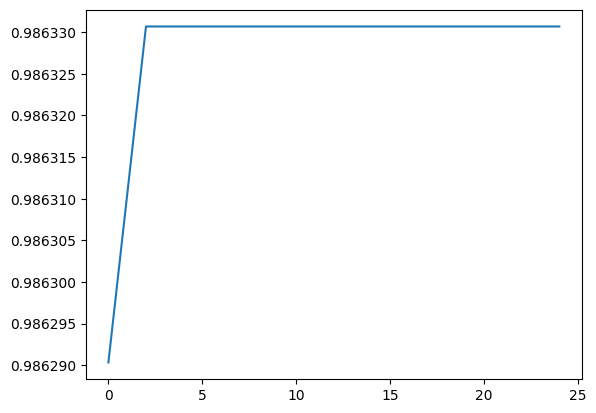

In [30]:
plt.plot(model.history.history["val_accuracy"])

# Graphical Testing

In [31]:
y_pred = model(np.array(x_data))

In [32]:
print(np.unique(y_pred))

[0.01248703]


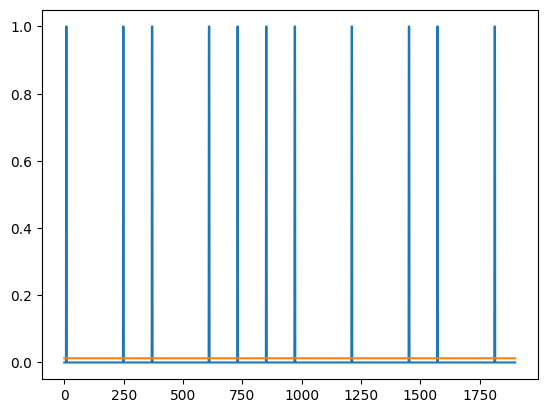

In [35]:
start = 77450
interval = 1900

scaled = np.array(y_pred[start : start + interval])

plt.plot(y_data[start : start + interval])
# plt.plot(y_pred[start:start+interval])
plt.plot(scaled)
plt.show()

In [ ]:
y_smoother = []
delta = 5
theshold = 0.75

y_smoother = [
    int(max(y_pred[i : i + delta]) > theshold) for i in range(len(y_pred) - delta)
]

for i in range(delta):
    y_smoother.append(0)


y_smoother = np.arrray(y_smoother)

In [ ]:
start = 77450
interval = 1900

plt.plot(y_data[start : start + interval])
# plt.plot(y_pred[start:start+interval])
plt.plot(y_smoother[start : start + interval])
plt.show()

In [ ]:
from matplotlib import rc

rc("animation", html="jshtml")
from math import *

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

In [ ]:
delta_i = 800

n = 1000 - delta_i
samplerate = 80
fr = n // samplerate  # Number of frames
sim_time = 100  # time for sim to fully run
inter = n / (sim_time * samplerate)

fig, axs = plt.subplots(1, 1, figsize=(13, 10))

# Line Initialization
(line1,) = axs.plot([], [], lw=2)
(line2,) = axs.plot([], [], lw=2)


# Titles
# axs.set_title('Wavefunction Over Time', size = fs)

# fig.text(0.5, 0.95, "V(x) = {},".format(V(x)), ha='center', fontsize = fs)
# # trans = axs[0,1].get_xaxis_transform() # x in data untis, y in axes fraction
# axs.text(-0.35,0, "Frame =", ha="center", fontsize = fs)
# # time = axs[0,1].annotate('', xy=(1.1, 1.1), annotation_clip = False)
# time_temp = '%.1f'
# time = axs[0,0].text(0.55, 0.5, '', transform=axs[0,0].transAxes)

# #Axes Initialization
axs.set_ylim(-0.5, 1.5)
axs.set_xlim(0, 800)

# axs.set_xlabel('$x$ $pos$ ($arb. units$)')     # add labels
# axs.set_ylabel('$\psi$ ($arb. units$)')
axs.grid()


# Initialization function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (
        line1,
        line2,
    )


# Animation function
def animate(i):
    # time.set_text(time_temp%(i))

    line1.set_data([j for j in range(delta_i)], y_data[i : i + delta_i])
    line2.set_data([j for j in range(delta_i)], y_pred[i : i + delta_i])
    # time.set_text(i*samplerate)
    return (
        line1,
        line2,
    )


# Call Animation
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=fr, interval=inter, blit=True
)
# plt.savefig('./h=0.02.pdf', format='pdf', dpi=1200,bbox_inches = 'tight')

In [ ]:
anim

In [ ]:
plt.plot(freq_list[:], x_test[59])

Testing with validation data

In [ ]:
x_valid_copy = x_valid
y_valid_copy = y_valid

In [ ]:
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)


x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)

In [ ]:
valid_pred = model(x_valid)
print(np.unique(valid_pred))

In [ ]:
start = 9970
interval = 1600

scaled = 2 * np.array(valid_pred[start : start + interval])

plt.plot(y_valid[start : start + interval])
# plt.plot(y_pred[start:start+interval])
plt.plot(scaled)
plt.show()

# Pytorch

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [45]:
CHANNELS = 7
SAMPLE_HZ = 250

In [61]:
class EEGNet(nn.Module):
    def __init__(
        self,
        n_classes,
        channels=CHANNELS,
        sample_hz=SAMPLE_HZ,
        dropout_rate=0.5,
        kernel_len=SAMPLE_HZ // 2,
        tfilter1=8,
        n_spatial_filters=2,
        tfilter2=None,  # tfilter1 * n_spatial_filters
        norm_rate=0.25,
        dropout_type="Dropout",
    ):
        super(EEGNet, self).__init__()
        self.nb_classes = n_classes
        self.channels = channels
        self.sample_hz = sample_hz
        self.dropout_rate = dropout_rate
        self.kernel_len = kernel_len
        self.tfilter1 = tfilter1
        self.n_spatial_filters = n_spatial_filters
        if tfilter2 is None:
            self.tfilter2 = tfilter1 * n_spatial_filters
        else:
            self.tfilter2 = tfilter2
        self.norm_rate = norm_rate

        if dropout_type == "Dropout2D":
            self.dropout = nn.Dropout2d
        elif dropout_type == "Dropout":
            self.dropout = nn.Dropout
        else:
            raise ValueError(
                "dropoutType must be one of Dropout2D or Dropout, passed as a string."
            )

        self.conv1 = nn.Conv2d(
            1,
            self.tfilter1,
            kernel_size=(1, self.kernel_len),
            padding=(0, self.kernel_len // 2),
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(self.tfilter1)
        self.depthwise = nn.Conv2d(
            self.tfilter1,
            self.tfilter1 * self.n_spatial_filters,
            kernel_size=(self.channels, 1),
            groups=self.tfilter1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(self.tfilter1 * self.n_spatial_filters)
        self.separable_conv = nn.Conv2d(
            self.tfilter1 * self.n_spatial_filters,
            self.tfilter2,
            kernel_size=(1, 16),
            padding=(0, 8),
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(self.tfilter2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(self.tfilter2 * 4, self.nb_classes)

    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.depthwise(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.avg_pool2d(x, kernel_size=(1, 4))
        x = self.dropout(p=self.dropout_rate)(x)

        x = self.separable_conv(x)
        x = self.bn3(x)
        x = F.elu(x)
        x = F.avg_pool2d(x, kernel_size=(1, 8))
        x = self.dropout(p=self.dropout_rate)(x)

        x = self.flatten(x)
        x = F.linear(
            x,
            self.dense.weight
            * torch.clamp(torch.norm(self.dense.weight), max=self.norm_rate)
            / torch.norm(self.dense.weight),
        )
        x = F.softmax(x, dim=1)

        return x

In [ ]:
"""
# %%
# Reshape x_data to a 3D array
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, shuffle=True
)
"""
x_data_3d = np.array(x_data)
y_data_3d = np.array(y_data)
x_train, x_test, y_train, y_test = train_test_split(
    x_data_3d, y_data_3d, test_size=0.2, random_state=42, shuffle=False
)

In [54]:
# reshape for EEGNet
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

In [66]:
x_train.shape

(198107, 13, 1)

In [ ]:
# convert to torch tensor
x_train_tensor = torch.from_numpy(x_train).float().to(device)
x_test_tensor = torch.from_numpy(x_test).float().to(device)

y_train_tensor = torch.from_numpy(y_train).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [56]:
# create dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [57]:
# create dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [63]:
# Define the loss function and optimizer

# create model
model = EEGNet(n_classes=2).to(device)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop

num_epochs = 10
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for batch_idx, (df, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(df)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * df.size(0)
        _, pred = torch.max(outputs, 1)
        train_acc += torch.sum(pred == target.data)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)

    # Validation
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (df, target) in enumerate(val_loader):
            outputs = model(df)
            loss = criterion(outputs, target)
            val_loss += loss.item() * df.size(0)
            _, pred = torch.max(outputs, 1)
            val_acc += torch.sum(pred == target.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

In [ ]:

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.constraints import max_norm
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten,
                          Input, MaxPooling2D, Permute, SeparableConv2D,
                          SpatialDropout2D)
from keras.models import Model
from keras.regularizers import l1_l2


def EEGNet(
    nb_classes,
    Chans=64,
    Samples=128,
    dropoutRate=0.5,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    norm_rate=0.25,
    dropoutType="Dropout",
):
    if dropoutType == "SpatialDropout2D":
        dropoutType = SpatialDropout2D
    elif dropoutType == "Dropout":
        dropoutType = Dropout
    else:
        raise ValueError(
            "dropoutType must be one of SpatialDropout2D "
            "or Dropout, passed as a string."
        )

    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = Conv2D(
        F1,
        (1, kernLength),
        padding="same",
        input_shape=(Chans, Samples, 1),
        use_bias=False,
    )(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D(
        (Chans, 1),
        use_bias=False,
        depth_multiplier=D,
        depthwise_constraint=max_norm(1.0),
    )(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation("elu")(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding="same")(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation("elu")(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    flatten = Flatten(name="flatten")(block2)

    dense = Dense(nb_classes, name="dense", kernel_constraint=max_norm(norm_rate))(
        flatten
    )
    softmax = Activation("softmax", name="softmax")(dense)

    return Model(inputs=input1, outputs=softmax)

In [ ]:
model = EEGNet(
    nb_classes=2,
    Chans=7,
    Samples=250,
    dropoutRate=0.5,
    kernLength=250 // 2,
    F1=8,
    D=2,
    F2=16,
    dropoutType="Dropout",
)

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 250, 1)

In [ ]:
total = len(y_data)
pos = np.sum(y_data)
neg = total - pos

class_weights = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}
class_weights

In [ ]:
# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(
    filepath="/tmp/checkpoint.h5", verbose=1, save_best_only=True
)

fittedModel = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=300,
    verbose=2,
    validation_data=(x_test, y_test),
    callbacks=[checkpointer],
    class_weight=class_weights,
)

Reshape for RNN

In [ ]:
# Reshape
x_valid = x_valid.reshape(1, x_valid.shape[0], x_valid.shape[1])
y_valid = y_valid.reshape(1, y_valid.shape[0])

In [ ]:
# Reverse Reshape
x_valid = x_valid.reshape(x_valid.shape[1], x_valid.shape[2], 1)
y_valid = y_valid.reshape(y_valid.shape[1], 1)

Prayer

from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
# Option 1: Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

In [ ]:
# Option 2: Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [ ]:
# Option 3: SVM
svm = SVC()
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)

In [ ]:
# Option 5: Naive Bayes
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

In [ ]:
print(np.unique(y_pred_nb))
print(nb.score(x_test, y_test))

In [ ]:
start = 0
interval = 24000

scaled = np.array(y_pred_nb[start : start + interval])

# plt.plot(y_test[start:start+interval])
# plt.plot(y_pred[start:start+interval])
plt.plot(scaled)
plt.show()

#Clear GPU

In [ ]:
tf.keras.backend.clear_session()